In [29]:
import pandas as pd
import numpy as np
import tensorflow as tf
import nltk
from nltk.corpus import stopwords
from keras.preprocessing.sequence import pad_sequences
import re
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, InputLayer, Activation, Flatten
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import seaborn as sns
import gensim
import gensim.downloader

In [30]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [31]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [32]:
# word2vec_vectors_emb = gensim.downloader.load('word2vec-google-news-300')
# fasttext_vectors_emb = gensim.downloader.load('fasttext-wiki-news-subwords-300')
glove_vectors_emb = gensim.downloader.load('glove-wiki-gigaword-50')

In [33]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")  

In [34]:
train['reviews']

0        This book was very informative, covering all a...
1        I am already a baseball fan and knew a bit abo...
2        I didn't like this product it smudged all unde...
3        I simply love the product. I appreciate print ...
4        It goes on very easily and makes my eyes look ...
                               ...                        
49995                         it does not work((((((((((((
49996    Really worthless, loud motor with absolutely n...
49997    Don't waste your money on this. It does nothin...
49998    Product does not remove ear wax. No suction, j...
49999    If you wear hearing aids these are great for r...
Name: reviews, Length: 50000, dtype: object

In [35]:
def convert_to_lower(text):
    # return the reviews after convering then to lowercase
    lower_text = text.copy()
    for i in range(len(text)):
        lower_text[i] = text[i].lower()
    return lower_text

In [36]:
def remove_punctuation(text):
    #stop_words = set(stopwords.words('english'))
    cleanedText = []
    for test_str in text:
        res = re.sub(r'[^\w\s]', '', test_str) 
        cleanedText.append(res)
    return cleanedText

In [37]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    without_stopwords_text  = text.copy()
    for i in range(len(text)):
        without_stopwords_text[i] = [w for w in text[i] if w not in stop_words]
    return without_stopwords_text

In [38]:
def perform_tokenization(text):
    t = Tokenizer()
    t.fit_on_texts(text)
    encoded = t.texts_to_sequences(text)
    return encoded

In [39]:
def get_dicts(train):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train)
    words_to_index = tokenizer.word_index
    return words_to_index

In [40]:
# def gloveVector():
#     wordMapping = {}
#     fileName = ''
#     with open(fileName, 'r', encoding='UTF-8') as f:
#         for line in f:
#             w_line = line.split()
#             curr_word = w_line[0]
#             wordMapping[curr_word] = np.array(w_line[1:], dtype=np.float64)
#     return (wordMapping)



In [41]:
# word_to_index = get_dicts(train)
# wordMap = gloveVector()
# vocabSize = len(word_to_index)

In [42]:
MAX_LENGTH = 50

In [43]:
# def embeddingMatrix():
#     vocab_len = len(word_to_index)
#     embed_vector_len = wordMap['moon'].shape[0]
#     emb_matrix = np.zeros((vocab_len, embed_vector_len))
#     for word, index in word_to_index.items():
#     embedding_vector = wordMap.get(word)
#     if embedding_vector is not None:
#         emb_matrix[index, :] = embedding_vector
#     embedding_layer = Embedding(input_dim=vocab_len, output_dim=embed_vector_len, input_length=MAX_LENGTH, weights = [emb_matrix], trainable=False)
#     return embedding_layer


In [44]:
def tokens(text):
    a = text.copy()
    for i in range(len(text)):
        a[i] = nltk.word_tokenize(text[i])
    return a

In [45]:
def perform_padding(data):
  z=[]
  for i in data:
    k = [r for j in i for r in j]
    result = np.zeros(MAX_LENGTH*50)
    result[:len(k)] = np.array(k)
    z.append(result)
  return (np.array(z,dtype='float64'))

In [46]:
def preprocess_data(data):
    reviews = data["reviews"]
    reviews = convert_to_lower(reviews)
    reviews = remove_punctuation(reviews)
    reviews = tokens(reviews)
    emb = []
    for i in reviews:
      tmp=[]
      for j in i:
        try:
          tmp.append(glove_vectors_emb[j])
        except KeyError:
          tmp.append(np.zeros((50)))
      emb.append(tmp)
    padded = perform_padding(emb)    
    return padded

In [47]:
preprocessed_reviews = preprocess_data(train)

In [48]:
preprocessed_test_reviews = preprocess_data(test)

In [49]:
def softmax_activation(x):
    exp_x = np.exp(x)
    return exp_x/np.sum(exp_x)

In [50]:
class NeuralNetGlove:

    def __init__(self, reviews, ratings):

        self.reviews = reviews
        self.ratings = ratings

    def build_nn(self,hiddenLayers,activationHidden):
        #add the input and output layer here; you can use either tensorflow or pytorch
        self.model = Sequential()
        self.model.add(InputLayer(input_shape=(MAX_LENGTH*50,)))
        for i in range(hiddenLayers):
            self.model.add(Dense(64,activation=activationHidden))
        self.model.add(Dense(5,activation='softmax'))
        self.model.compile(loss='categorical_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])
        self.model.summary()
        
    def train_nn(self,batch_size,epochs):
        # write the training loop here; you can use either tensorflow or pytorch
        # print validation accuracy
        y_train = tf.keras.utils.to_categorical(self.ratings,num_classes=5)
        self.history = self.model.fit(self.reviews, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)
        

    def predict(self, reviews):
        # return a list containing all the ratings predicted by the trained model
        y_pred = self.model.predict(reviews)
        pred1 = []
        for i in range(len(y_pred)):
            pred1.append(np.argmax(y_pred[i])+1)
        return pred1

In [51]:
train_rating_list = train['ratings'].to_list()
Y = [str(i-1) for i in train_rating_list]

In [52]:
###### Code to find the model with best training and test set 
def bestModelNN():
    trainAccuraciesReLU = []
    testAccuraciesReLU = []
    trainAccuraciesSigmoid = []
    testAccuraciesSigmoid = []
    
    for i in range(0,5):
        M = NeuralNetGlove(preprocessed_reviews,Y)
        M.build_nn(hiddenLayers=i,activationHidden='sigmoid')
        M.train_nn(64,15)
        y_pred = M.predict(preprocessed_test_reviews)
        accuracyTest = accuracy_score(test['ratings'],y_pred)
        accuracyTrain = M.history.history['accuracy'][-1]
        trainAccuraciesSigmoid.append(accuracyTrain)
        testAccuraciesSigmoid.append(accuracyTest)
        del M
        
    for i in range(0,5):
        M = NeuralNetGlove(preprocessed_reviews,Y)
        M.build_nn(hiddenLayers=i,activationHidden='relu')
        M.train_nn(64,15)
        y_pred = M.predict(preprocessed_test_reviews)
        accuracyTest = accuracy_score(test['ratings'],y_pred)
        accuracyTrain = M.history.history['accuracy'][-1]
        trainAccuraciesReLU.append(accuracyTrain)
        testAccuraciesReLU.append(accuracyTest)
        del M 
        
    print(trainAccuraciesReLU)
    print(testAccuraciesReLU)
    print(trainAccuraciesSigmoid)
    print(testAccuraciesSigmoid)
    return trainAccuraciesReLU, testAccuraciesReLU, trainAccuraciesSigmoid, testAccuraciesSigmoid



In [76]:
##### Develop Report for the best model and prediction for some examples
def report(y_pred,test,Model):
    Classification_report = classification_report(test['ratings'],y_pred,target_names=['1','2','3','4','5'])
    cm  = confusion_matrix(test['ratings'],y_pred)
    print("Classification Report : \n",Classification_report)
    print("Heat Map :\n")
    sns.heatmap(cm,cmap="Blues",annot=True,fmt='.4g',xticklabels=['1','2','3','4','5'],yticklabels=['1','2','3','4','5'])
    #tried_examples = [['I like it but dont think I would buy again.'], ['Nice looking cleaner but way smaller than 2 liters. Not as advertised.'],['Total waste of money, I used all 10 of these and got 0 results from it.']] 
    # Create the pandas DataFrame 
    #df = pd.DataFrame(tried_examples, columns = ['reviews']) 
    #pre_tried_examples = preprocess_data(df,word_to_index)
    #z = Model.predict(pre_tried_examples)
    #print("Examples :\n",df)
    #print("Predicted Values: \n",z)

In [54]:
trainAccuraciesReLU, testAccuraciesReLU, trainAccuraciesSigmoid, testAccuraciesSigmoid = bestModelNN()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 5)                 12505     
Total params: 12,505
Trainable params: 12,505
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
625/625 [==============================] - 2s 3ms/step - loss: 1.1553 - accuracy: 0.6234 - val_loss: 1.2397 - val_accuracy: 0.5744
Epoch 2/15
625/625 [==============================] - 2s 3ms/step - loss: 0.9743 - accuracy: 0.6855 - val_loss: 1.1773 - val_accuracy: 0.5754
Epoch 3/15
625/625 [==============================] - 2s 3ms/step - loss: 0.9340 - accuracy: 0.6864 - val_loss: 1.1413 - val_accuracy: 0.5795
Epoch 4/15
625/625 [==============================] - 2s 3ms/step - loss: 0.9104 - accuracy: 0.6858 - val_loss: 1.1254 - val_accuracy: 0.5829
Epoch 5/15
625/625 [==============================] - 2s 3ms/step - loss: 0.

##### Accuracies

In [56]:
all_accuracy = pd.DataFrame(columns=['layers','train_accuracy_sigmoid','test_accuracy_sigmoid','train_accuracy_relu','test_accuracy_relu'],index=np.arange(5))

In [58]:
all_accuracy['layers'] = np.arange(5)
all_accuracy['train_accuracy_sigmoid']= trainAccuraciesSigmoid
all_accuracy['test_accuracy_sigmoid'] = testAccuraciesSigmoid
all_accuracy['train_accuracy_relu'] = trainAccuraciesReLU
all_accuracy['test_accuracy_relu'] = testAccuraciesReLU
all_accuracy

,layers,train_accuracy_sigmoid,test_accuracy_sigmoid,train_accuracy_relu,test_accuracy_relu
0,0,0.706575,0.6009,0.706600,0.6032
1,1,0.712000,0.6113,0.767150,0.6119
2,2,0.708400,0.6143,0.805650,0.6003
3,3,0.705675,0.6142,0.832000,0.5942
4,4,0.700650,0.6076,0.852875,0.5876


In [60]:
import matplotlib.pyplot as plt

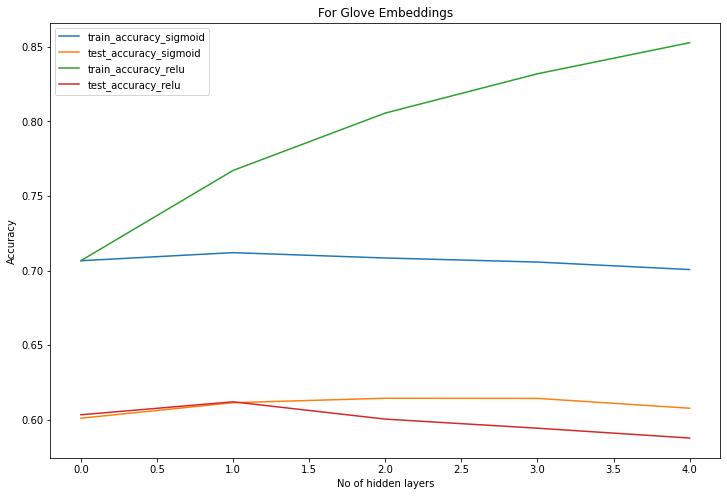

In [64]:
plt.figure(figsize=(12,8))
plt.plot(all_accuracy['layers'],all_accuracy['train_accuracy_sigmoid'],label='train_accuracy_sigmoid')
plt.plot(all_accuracy['layers'],all_accuracy['test_accuracy_sigmoid'],label='test_accuracy_sigmoid')
plt.plot(all_accuracy['layers'],all_accuracy['train_accuracy_relu'],label='train_accuracy_relu')
plt.plot(all_accuracy['layers'],all_accuracy['test_accuracy_relu'],label='test_accuracy_relu')
plt.title('For Glove Embeddings')
plt.xlabel("No of hidden layers")
plt.ylabel("Accuracy")
plt.legend()

In [ ]:
#Best Model
# 1. Layer:1   , Activation: ReLU


In [65]:
#Training Best Model:


In [67]:
Best_model = NeuralNetGlove(preprocessed_reviews,Y)
Best_model.build_nn(hiddenLayers=1,activationHidden='relu')
Best_model.train_nn(64,15)
y_pred = Best_model.predict(preprocessed_test_reviews)
accuracyTest = accuracy_score(test['ratings'],y_pred)
accuracyTrain = Best_model.history.history['accuracy'][-1]
print(accuracyTrain)
print(accuracyTest)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 64)                160064    
_________________________________________________________________
dense_33 (Dense)             (None, 5)                 325       
Total params: 160,389
Trainable params: 160,389
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
625/625 [==============================] - 3s 4ms/step - loss: 1.1023 - accuracy: 0.6431 - val_loss: 1.1607 - val_accuracy: 0.5752
Epoch 2/15
625/625 [==============================] - 2s 4ms/step - loss: 0.8964 - accuracy: 0.6947 - val_loss: 1.0973 - val_accuracy: 0.5858
Epoch 3/15
625/625 [==============================] - 2s 4ms/step - loss: 0.8599 - accuracy: 0.6976 - val_loss: 1.0760 - val_accuracy: 0.5944
Epoch 4/15
625/625 [==============================] - 2s 4ms/step - loss: 0.8222 - 

NameError: ignored

In [69]:
accuracyTrain = Best_model.history.history['accuracy'][-1]
print(accuracyTrain)
print(accuracyTest)

0.7691749930381775
0.6137


In [ ]:
### Prediction GUI

In [70]:
import ipywidgets as widgets
from IPython.display import display

In [96]:
def preprocess_test(input):
  input = input.split()
  
  input = convert_to_lower(input)
  input = tokens(input)
  emb=[]
  for i in input:
    try:
      emb.append(glove_vectors_emb[i])
    except KeyError:
      emb.append(np.zeros((50)))
  padded = perform_padding(emb)    
  return padded


In [107]:
k = widgets.Textarea(
    value="",
    placeholder='Type something',
    description='String:',
    disabled=False)
button = widgets.Button(description="Predict!")
output = widgets.Output()
display(k,button, output)
def on_button_clicked(b):
    output.clear_output()
    if k.value == "":
      output.clear_output()
    else :
        with output:
            ##### Predict the k.value 
            #prediction = predict(k.value)
            text = preprocess_test(k.value)
            prediction = Best_model.predict(text)
            print(prediction)
    
button.on_click(on_button_clicked)

Textarea(value='', description='String:', placeholder='Type something')

Button(description='Predict!', style=ButtonStyle())

Output()

In [ ]:
#Report for Best model

Classification Report : 
               precision    recall  f1-score   support

           1       0.48      0.37      0.42      1271
           2       0.25      0.05      0.09       630
           3       0.28      0.18      0.22       911
           4       0.27      0.07      0.11      1404
           5       0.67      0.93      0.78      5784

    accuracy                           0.61     10000
   macro avg       0.39      0.32      0.32     10000
weighted avg       0.53      0.61      0.55     10000

Heat Map :



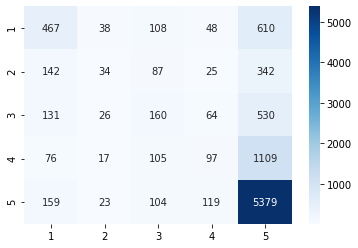

In [77]:
report(y_pred,test,Model=Best_model)

### Different Models

#### 1. Hiden layers: 0, activation: Sigmoid

In [98]:
Sigmoid0 = NeuralNetGlove(preprocessed_reviews,Y)
Sigmoid0.build_nn(hiddenLayers=0,activationHidden='sigmoid')
Sigmoid0.train_nn(64,15)
y_pred = Sigmoid0.predict(preprocessed_test_reviews)
accuracyTest = accuracy_score(test['ratings'],y_pred)
accuracyTrain = Sigmoid0.history.history['accuracy'][-1]
print(accuracyTrain)
print(accuracyTest)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 5)                 12505     
Total params: 12,505
Trainable params: 12,505
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
625/625 [==============================] - 2s 3ms/step - loss: 1.1403 - accuracy: 0.6289 - val_loss: 1.2325 - val_accuracy: 0.5739
Epoch 2/15
625/625 [==============================] - 2s 3ms/step - loss: 0.9808 - accuracy: 0.6833 - val_loss: 1.1706 - val_accuracy: 0.5770
Epoch 3/15
625/625 [==============================] - 2s 3ms/step - loss: 0.9408 - accuracy: 0.6836 - val_loss: 1.1439 - val_accuracy: 0.5802
Epoch 4/15
625/625 [==============================] - 2s 3ms/step - loss: 0.9049 - accuracy: 0.6899 - val_loss: 1.1190 - val_accuracy: 0.5839
Epoch 5/15
625/625 [==============================] - 2s 3ms/step - loss: 0

Classification Report : 
               precision    recall  f1-score   support

           1       0.52      0.23      0.32      1271
           2       0.25      0.01      0.03       630
           3       0.28      0.07      0.11       911
           4       0.21      0.02      0.04      1404
           5       0.63      0.98      0.76      5784

    accuracy                           0.60     10000
   macro avg       0.38      0.26      0.25     10000
weighted avg       0.50      0.60      0.50     10000

Heat Map :



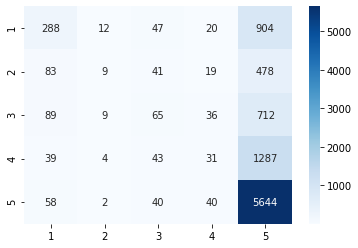

In [99]:
report(y_pred,test,Model=Sigmoid0)

#### 2. Hiden layers: 1, activation: Sigmoid

In [100]:
Sigmoid1 = NeuralNetGlove(preprocessed_reviews,Y)
Sigmoid1.build_nn(hiddenLayers=1,activationHidden='sigmoid')
Sigmoid1.train_nn(64,15)
y_pred = Sigmoid1.predict(preprocessed_test_reviews)
accuracyTest = accuracy_score(test['ratings'],y_pred)
accuracyTrain = Sigmoid1.history.history['accuracy'][-1]
print(accuracyTrain)
print(accuracyTest)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 64)                160064    
_________________________________________________________________
dense_36 (Dense)             (None, 5)                 325       
Total params: 160,389
Trainable params: 160,389
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
625/625 [==============================] - 3s 4ms/step - loss: 1.0830 - accuracy: 0.6372 - val_loss: 1.2026 - val_accuracy: 0.5742
Epoch 2/15
625/625 [==============================] - 2s 4ms/step - loss: 0.9443 - accuracy: 0.6868 - val_loss: 1.1428 - val_accuracy: 0.5747
Epoch 3/15
625/625 [==============================] - 2s 4ms/step - loss: 0.9017 - accuracy: 0.6860 - val_loss: 1.1016 - val_accuracy: 0.5819
Epoch 4/15
625/625 [==============================] - 2s 4ms/step - loss: 0.8746 - 

Classification Report : 
               precision    recall  f1-score   support

           1       0.52      0.27      0.35      1271
           2       0.25      0.01      0.02       630
           3       0.29      0.10      0.15       911
           4       0.24      0.03      0.05      1404
           5       0.63      0.97      0.77      5784

    accuracy                           0.61     10000
   macro avg       0.39      0.28      0.27     10000
weighted avg       0.51      0.61      0.51     10000

Heat Map :



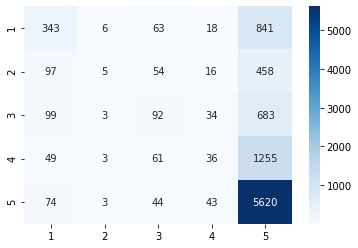

In [101]:
report(y_pred,test,Model=Sigmoid1)

### 3. Hiiden layers: 0, activation: ReLU

In [102]:
ReLU0 = NeuralNetGlove(preprocessed_reviews,Y)
ReLU0.build_nn(hiddenLayers=0,activationHidden='relu')
ReLU0.train_nn(64,15)
y_pred = ReLU0.predict(preprocessed_test_reviews)
accuracyTest = accuracy_score(test['ratings'],y_pred)
accuracyTrain = ReLU0.history.history['accuracy'][-1]
print(accuracyTrain)
print(accuracyTest)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 5)                 12505     
Total params: 12,505
Trainable params: 12,505
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
625/625 [==============================] - 2s 3ms/step - loss: 1.2874 - accuracy: 0.5379 - val_loss: 1.2496 - val_accuracy: 0.5743
Epoch 2/15
625/625 [==============================] - 2s 3ms/step - loss: 0.9981 - accuracy: 0.6798 - val_loss: 1.1970 - val_accuracy: 0.5745
Epoch 3/15
625/625 [==============================] - 2s 3ms/step - loss: 0.9405 - accuracy: 0.6874 - val_loss: 1.1615 - val_accuracy: 0.5765
Epoch 4/15
625/625 [==============================] - 2s 3ms/step - loss: 0.9193 - accuracy: 0.6872 - val_loss: 1.1420 - val_accuracy: 0.5780
Epoch 5/15
625/625 [==============================] - 2s 3ms/step - loss: 0

Classification Report : 
               precision    recall  f1-score   support

           1       0.54      0.20      0.29      1271
           2       0.15      0.00      0.01       630
           3       0.29      0.11      0.16       911
           4       0.28      0.01      0.03      1404
           5       0.62      0.98      0.76      5784

    accuracy                           0.60     10000
   macro avg       0.38      0.26      0.25     10000
weighted avg       0.50      0.60      0.49     10000

Heat Map :



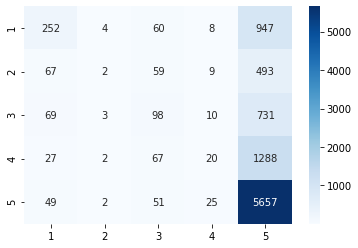

In [103]:
report(y_pred,test,Model=ReLU0)

### 1. Hiiden layers: 1, activation: ReLU

In [104]:
ReLU1 = NeuralNetGlove(preprocessed_reviews,Y)
ReLU1.build_nn(hiddenLayers=0,activationHidden='sigmoid')
ReLU1.train_nn(64,15)
y_pred = ReLU1.predict(preprocessed_test_reviews)
accuracyTest = accuracy_score(test['ratings'],y_pred)
accuracyTrain = ReLU1.history.history['accuracy'][-1]
print(accuracyTrain)
print(accuracyTest)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 5)                 12505     
Total params: 12,505
Trainable params: 12,505
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
625/625 [==============================] - 2s 3ms/step - loss: 1.1529 - accuracy: 0.6117 - val_loss: 1.2386 - val_accuracy: 0.5742
Epoch 2/15
625/625 [==============================] - 2s 3ms/step - loss: 0.9700 - accuracy: 0.6895 - val_loss: 1.1775 - val_accuracy: 0.5754
Epoch 3/15
625/625 [==============================] - 2s 3ms/step - loss: 0.9381 - accuracy: 0.6843 - val_loss: 1.1560 - val_accuracy: 0.5761
Epoch 4/15
625/625 [==============================] - 2s 3ms/step - loss: 0.9019 - accuracy: 0.6904 - val_loss: 1.1252 - val_accuracy: 0.5805
Epoch 5/15
625/625 [==============================] - 2s 3ms/step - loss: 0

Classification Report : 
               precision    recall  f1-score   support

           1       0.52      0.21      0.30      1271
           2       0.00      0.00      0.00       630
           3       0.27      0.08      0.12       911
           4       0.24      0.02      0.04      1404
           5       0.62      0.98      0.76      5784

    accuracy                           0.60     10000
   macro avg       0.33      0.26      0.25     10000
weighted avg       0.48      0.60      0.50     10000

Heat Map :



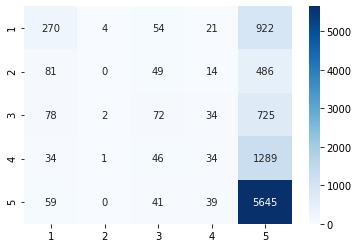

In [105]:
report(y_pred,test,Model=ReLU1)